In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('BCHAIN-MKPRU.csv',header=0,index_col=0,parse_dates = True)
df2 = pd.read_csv('LBMA-GOLD.csv',header=0,index_col=0,parse_dates = True)

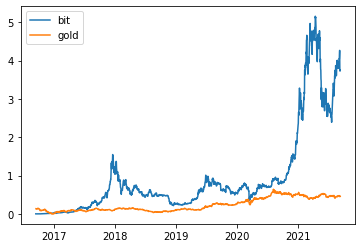

In [3]:
# 归一
df1 = (df1 - df1.min())/df1.mean()
df2 = (df2 - df2.min())/df2.mean()
plt.plot(df1,label = 'bit')
plt.plot(df2,label ='gold')
plt.legend()

In [4]:
import pandas as pd
import numpy as np
import datetime
import pytz  #时区函数
import statsmodels.api as sm  #用于单位根检验
import matplotlib.pyplot as plt  #画图
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA  #ARIMA模型
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #acf和pacf检测

In [10]:
#转换为本地时间戳
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))
#数据导入
bitcoin= pd.read_csv('BCHAIN-MKPRU.csv',header=0,index_col=0,parse_dates = True)
# df2 = pd.read_csv('LBMA-GOLD.csv',header=0,index_col=0,parse_dates = True)
#数据整理，按天合并，并对空缺值补前一个非空值
# bitcoin['Date'] = bitcoin['Date'].dt.tz_localize(None)
# # bitcoin = bitcoin.groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
# bitcoin = bitcoin.set_index('Date')
# bitcoin = bitcoin[['Value']]
bitcoin['Value'] = bitcoin['Value'].fillna(method='ffill')

df2['USD (PM)'] = df2['USD (PM)'].fillna(method='ffill')
#拆分训练集和测试集，训练集时间为2018年12月17日至2020年3月31日
#测试集时间为2020年4月1日至4月20日
splitDate = '2020-11-9'
bitcoin_train = bitcoin.loc[bitcoin.index < splitDate]
bitcoin_test =bitcoin.loc[bitcoin.index > splitDate]
goldtrain = df2.loc[df2.index < splitDate]

In [7]:
bitcoin_train

,Value
Date,
2016-09-11,621.65
2016-09-12,609.67
2016-09-13,610.92
2016-09-14,608.82
2016-09-15,610.38
...,...
2020-11-04,14023.31
2020-11-05,14155.59
2020-11-06,15591.39


No handles with labels found to put in legend.


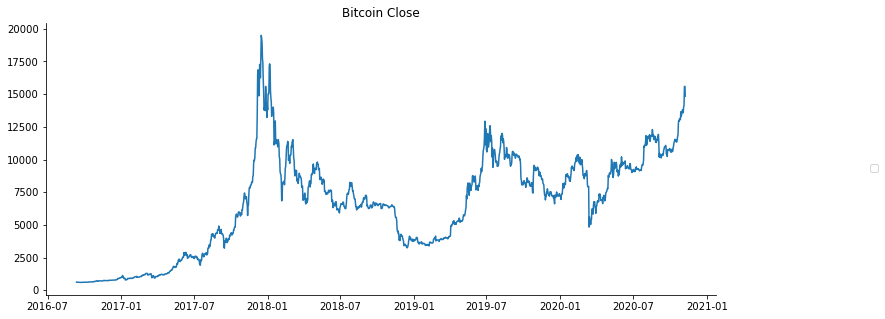

In [8]:
#画出数据的分布图
import seaborn as sns
plt.figure(figsize=(12,5))
plt.plot(bitcoin_train)
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title('Bitcoin Close')
sns.despine()

In [11]:
#单位根的检验成果
print(sm.tsa.stattools.adfuller(bitcoin_train))
print(sm.tsa.stattools.adfuller(goldtrain))


(-1.775100339499994, 0.3928918591874859, 10, 1509, {'1%': -3.434690926976026, '5%': -2.863457245470903, '10%': -2.5677907166982643}, 21686.740586907476)
(1.1486444620996479, 0.995611129769795, 22, 1030, {'1%': -3.436714730058834, '5%': -2.8643501440982058, '10%': -2.5682662399849185}, -6842.924383017809)


- 注：第一项如果比花括号内1%，5%，10%对应的值都小则代表数据较为平稳，第二项表示P-value即假设检验的依据，小于0.05表示该独立变量与输出结果有关，值越接近于0越好。
- 由该结果表明数据的平稳性较差，需要做差分，所以首先考虑做一阶差分

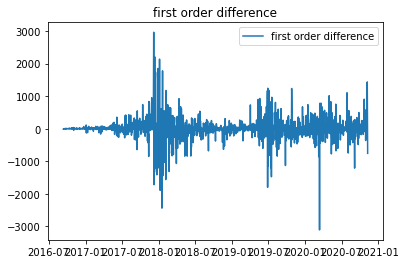

In [13]:
#看序列一阶差分后的平稳性
bitcoin_diff = bitcoin_train.diff(1)
bitcoin_diff = bitcoin_diff.dropna()
plt.plot(bitcoin_diff, label='first order difference')
plt.legend()
plt.title('first order difference')
plt.show()

C:\Users\TRACYT~1\AppData\Local\Temp/ipykernel_24212/3460912034.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()
C:\Users\TRACYT~1\AppData\Local\Temp/ipykernel_24212/3460912034.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pacf.show()


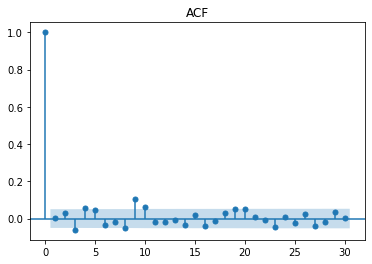

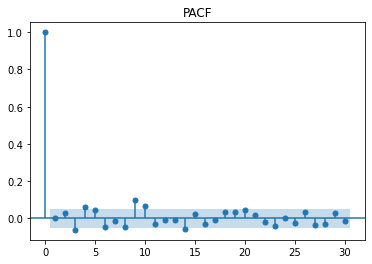

In [18]:
#绘制acf图像
# plt.subplot(2,1,1)
acf = plot_acf(bitcoin_diff, lags=30)
plt.title('ACF')
acf.show()
#绘制pacf图像
# plt.subplot(2,1,2)
pacf = plot_pacf(bitcoin_diff, lags=30)
plt.title('PACF')
pacf.show()
plt.show()

- 由图可以看出仅一阶差分已较为平稳，故d值取1，而且由ACF和PACF图可以确定p,q值均为1时，保证95%的数据都基本落在置信区间内。

In [78]:
model = ARIMA(bitcoin_train, order=(1,1,1))
result = model.fit()
print(result.summary()) #对模型进行分析
print(result.conf_int()) #查看每个系数的置信区间

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.wa

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 1519
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11016.416
Method:                       css-mle   S.D. of innovations            341.543
Date:                Sat, 19 Feb 2022   AIC                          22040.832
Time:                        13:07:15   BIC                          22062.135
Sample:                    09-12-2016   HQIC                         22048.763
                         - 11-08-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.4042      9.488      0.991      0.322      -9.193      28.001
ar.L1.D.Value     0.8898      0.153      5.815      0.000       0.590       1.190
ma.L1.D.Value    -0.8806      0.158     

In [79]:
#用测试集预测数据
pred = result.predict(start = 10 ,end=len(bitcoin_train), dynamic=True, typ='levels')
pred

2016-09-21      617.515184
2016-09-22      626.430871
2016-09-23      635.400393
2016-09-24      644.417818
2016-09-25      653.477865
                  ...     
2020-11-05    14775.750667
2020-11-06    14785.154829
2020-11-07    14794.558991
2020-11-08    14803.963153
2020-11-09    14813.367314
Freq: D, Length: 1511, dtype: float64

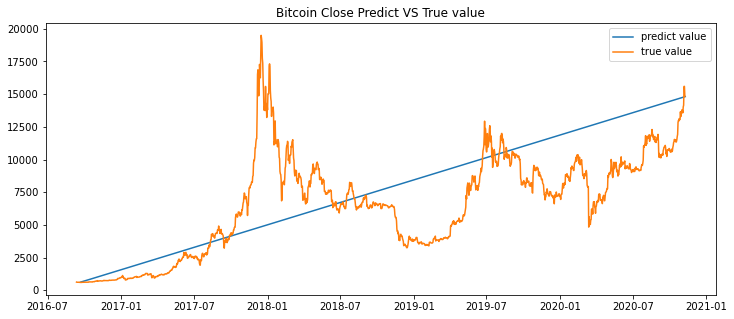

In [80]:
plt.figure(figsize=(12,5))
plt.title('Bitcoin Close Predict VS True value')
plt.plot(pred, label='predict value')
plt.plot(bitcoin_train, label='true value')
plt.legend()
plt.show()

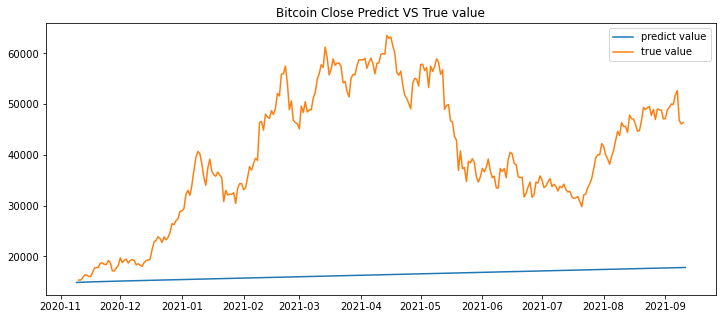

In [81]:
pred = result.predict(start = 1520 ,end=len(df1), dynamic=True, typ='levels')
plt.figure(figsize=(12,5))
plt.title('Bitcoin Close Predict VS True value')
plt.plot(pred, label='predict value')
plt.plot(bitcoin_test, label='true value')
plt.legend()
plt.show()

In [20]:
import pandas as pd
import datetime
import pytz 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [44]:
#分割测试集和训练集（与之前AMIRA模型分割相同）
splitdate = '2020-12-31'
bitcoin_train = bitcoin.loc[bitcoin.index < splitdate]
bitcoin_test = bitcoin.loc[bitcoin.index > splitdate]

In [45]:
training_set = bitcoin_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

In [48]:
#规范化处理和数据集的重塑
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
Y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
# bitcoin_train.plot(style='', figsize=(15,5), title='Bitcoin Close')
# bitcoin_test.rename(columns={'Value':'Test Set'}).join(bitcoin_train.rename(columns={'Value': 'Training Set'}), how='outer').plot(figsize=(14,6), title='Close', style='',color = ['#00338D','orange'])
# plt.xlim('2016-11-08', '2021-9-10')
# plt.legend()
# plt.title('Bitcoin')
# plt.savefig('Bitcoin Train Test Split.png')
# plt.show()

In [57]:
splitdate = '2020-12-31'
gold_train = df2.loc[df2.index < splitdate]
gold_test = df2.loc[df2.index > splitdate]
training_set = gold_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
Y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
# bitcoin_train.plot(style='', figsize=(15,5), title='Bitcoin Close')
# bitcoin_test.rename(columns={'Value':'Test Set'}).join(bitcoin_train.rename(columns={'Value': 'Training Set'}), how='outer').plot(figsize=(14,6), title='Close', style='',color = ['#00338D','orange'])
# plt.xlim('2016-11-08', '2021-9-10')
# plt.legend()
# plt.title('Gold')
# plt.savefig('Gold Train Test Split.png')
# plt.show()

In [58]:
#建立LSTM模型
model = Sequential()
model.add(LSTM(240, activation='sigmoid', input_shape=(1,1)))
model.add(Dropout(0.2)) 
model.add(Dense(1)) #输出层使用全连接层，只要一个输出节点
model.compile(optimizer='adam', loss='mean_squared_error')  #选择优化器和损失函数
model.fit(X_train, Y_train, epochs=100, batch_size=50, verbose=2)
print(model.summary())

Epoch 1/100
22/22 - 1s - loss: 0.0913 - 998ms/epoch - 45ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0856 - 103ms/epoch - 5ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0758 - 84ms/epoch - 4ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0706 - 67ms/epoch - 3ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0661 - 91ms/epoch - 4ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0582 - 88ms/epoch - 4ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0574 - 68ms/epoch - 3ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0528 - 93ms/epoch - 4ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0502 - 84ms/epoch - 4ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0471 - 71ms/epoch - 3ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0423 - 90ms/epoch - 4ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0415 - 93ms/epoch - 4ms/step
Epoch 13/100
22/22 - 0s - loss: 0.0366 - 82ms/epoch - 4ms/step
Epoch 14/100
22/22 - 0s - loss: 0.0355 - 66ms/epoch - 3ms/step
Epoch 15/100
22/22 - 0s - loss: 0.0332 - 92ms/epoch - 4ms/step
Epoch 16/100
22/22 - 0s - loss: 0.0312 - 82ms/epoch - 4ms/ste

In [59]:
#预测
test_set = gold_test['USD (PM)'].values
# len(test_set)
test_set

array([0.55819216, 0.55624617, 0.55051062, 0.54241939, 0.50336301,
       0.49267713, 0.48858031, 0.50059766, 0.48892171, 0.487044  ,
       0.48298132, 0.48410794, 0.49906135, 0.50281677, 0.49639841,
       0.49923205, 0.49906135, 0.48977522, 0.49708122, 0.50397754,
       0.50339715, 0.48301546, 0.48462005, 0.45078712, 0.46242892,
       0.48448349, 0.48745368, 0.48953623, 0.48779508, 0.47157849,
       0.47222716, 0.45648853, 0.44723653, 0.44208137, 0.45099196,
       0.46550154, 0.46017567, 0.452221  , 0.44651959, 0.42139241,
       0.41545201, 0.40841913, 0.39991823, 0.40039619, 0.38957375,
       0.38329195, 0.40367365, 0.40319569, 0.40869226, 0.39541172,
       0.40828257, 0.4160324 , 0.4123794 , 0.40981888, 0.41616896,
       0.41681762, 0.41002372, 0.41295978, 0.41760285, 0.41384743,
       0.39619695, 0.38117526, 0.38602317, 0.4099213 , 0.42262146,
       0.41811495, 0.43002988, 0.42026578, 0.41456437, 0.42487471,
       0.41640794, 0.43119064, 0.44296901, 0.44300315, 0.44529

In [60]:
inputs = np.reshape(test_set, (len(test_set), 1))
len(inputs)

175

In [61]:
inputs = scaler.fit_transform(inputs)

In [63]:
pred = model.predict(inputs)
pred = scaler.inverse_transform(pred)
gold_test['Prediction'] = pred
len(gold_test)

C:\Users\TRACYT~1\AppData\Local\Temp/ipykernel_24212/1609924955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_test['Prediction'] = pred


175

In [54]:
# bitcoin_all = pd.concat([bitcoin_test, bitcoin_train], sort=True)
# bitcoin_all

In [143]:
# #将预测得到的数据与训练集进行合并
# final_data = bitcoin_all
# final_data = final_data.reset_index()
# final_data = final_data.rename(columns={'Prediction': 'LSTM'})
# final_data = final_data[['Date', 'Value', 'LSTM']]
# final_data

,Date,Value,LSTM
0,2021-01-01,28982.56,29413.447266
1,2021-01-02,29393.75,29810.144531
2,2021-01-03,32195.46,32506.960938
3,2021-01-04,33000.78,33278.976562
4,2021-01-05,32035.03,32352.958984
...,...,...,...
1820,2020-12-26,24693.58,NaN
1821,2020-12-27,26443.21,NaN
1822,2020-12-28,26246.58,NaN
1823,2020-12-29,27036.69,NaN


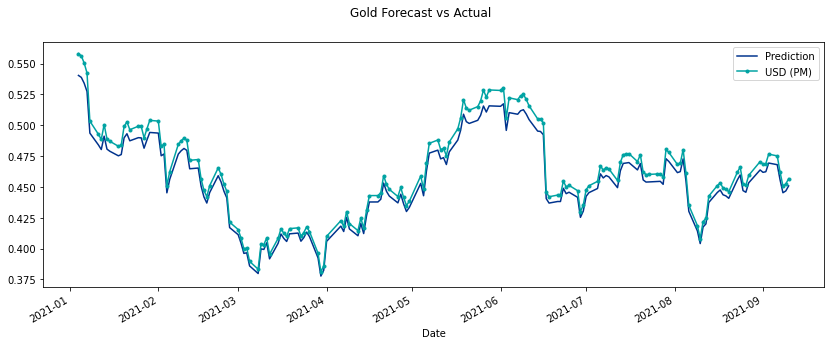

MSE = 5.548782230389358e-05 MAE =  0.0069105297262388315


In [66]:
#画出与真实值的比较图像
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
gold_test[['Prediction','USD (PM)']].plot(ax=ax, style=['-', '.-'], color = ['#00338D','#00A3A3'])
plt.suptitle('Gold Forecast vs Actual')
plt.show()
PreSquE = mean_squared_error(y_true=gold_test['USD (PM)'], y_pred=gold_test['Prediction'])
PreAbE = mean_absolute_error(y_true=gold_test['USD (PM)'], y_pred=gold_test['Prediction'])
print("MSE =", PreSquE, "MAE = ", PreAbE)

In [31]:
#计算误差
PreSquE = mean_squared_error(y_true=bitcoin_test['Value'], y_pred=bitcoin_test['Prediction'])
PreAbE = mean_absolute_error(y_true=bitcoin_test['Value'], y_pred=bitcoin_test['Prediction'])
print(PreSquE, PreAbE)

1709603.3303341193 1021.0610137722332


In [146]:
dim = [23, 56, 128, 256]  #网络节点数分别取列表内值时结果

IndexError: list index out of range